# Perkenalan

Nama      : Immanuel Yosia Alfrenco

Batch     : FTDS-015

Dataset   : https://www.kaggle.com/datasets/techsash/waste-classification-data

Objective : Melakukan klasifikasi jenis sampah menggunakan dataset yang sudah ada.


## Latar Belakang

Pengelolaan sampah merupakan salah satu yang harus dihadapi masyarakat sekarang. Banyaknya aktivitas dan kegiatan manusia yang menghasilkan limbah/sampah semakin banyak. Limbah sampah yang menumpuk ini harus dikelola sesuai dengan jenisnya yaitu organic dan anorganic. Dataset ini berisi data gambar sampah organic dan anorganic dimana akan coba untuk diklasifikasikan menggunakan model CNN yang akan dibuat. Model CNN yang akan dibuat ini diharapkan bisa melakukan klaasifikasi jenis sampah dengan baik sehingga bisa membedakan sampah organic dan anorganic dengan gambar yang ada sehingga sampah tersebut bisa dikelola sesuai jenisnya.

# Import Libraries

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Activation

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [ ]:
!mkdir -p ~/.kaggle # membuat folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paste kaggle.json ke folder kaggle 

!mkdir ./kaggle # membuat folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle # memindahkan file kaggle.json ke folder kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json # perizinan akses
!ls ~/.kaggle # cek list data yang ada di folder kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d techsash/waste-classification-data # download dataset dari kaggle

 98% 417M/427M [00:11<00:00, 49.6MB/s]
100% 427M/427M [00:11<00:00, 40.3MB/s]


In [ ]:
!unzip -q /content/waste-classification-data.zip -d images # unzip dataset yang sudah di download

In [ ]:
os.listdir('/content/images/DATASET') # melihat list isi dataset

['TEST', 'TRAIN']

In [ ]:
main_path = '/content/images/DATASET' # set main path dataset yang akan diakses

In [ ]:
train_dir = os.path.join(main_path, 'TRAIN')
test_dir = os.path.join(main_path, 'TEST')

In [ ]:
# Mengecek jumlah dataset dalam train
print('train set: \n' + '='*50)
organic = len(os.listdir(os.path.join(train_dir, 'O')))
recycle = len(os.listdir(os.path.join(train_dir, 'R')))
print(f'jumlah organic= {organic}')
print(f'jumlah recycle= {recycle}')

train set: 
jumlah organic= 12565
jumlah recycle= 9999


In [ ]:
# Mengecek jumlah dataset dalam test
print('test set: \n' + '='*50)
organic = len(os.listdir(os.path.join(test_dir, 'O')))
recycle = len(os.listdir(os.path.join(test_dir, 'R')))
print(f'jumlah organic= {organic}')
print(f'jumlah recycle= {recycle}')

test set: 
jumlah organic= 1401
jumlah recycle= 1112


In [ ]:
train_organic = glob.glob(train_dir+"/O/*.jpg")
train_recycle = glob.glob(train_dir+"/R/*.jpg")

test_organic = glob.glob(test_dir+"/O/*.jpg")
test_recycle = glob.glob(test_dir+"/R/*.jpg")

# Exploratory Data Analysis (EDA)

In [ ]:
# Membuat dataframe yang berisi data gambar dan juga jenisnya
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_organic + train_recycle)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_organic + test_recycle)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [ ]:
print(train_df.shape)
train_df.head()

(22564, 2)


,images,label
0,/content/images/DATASET/TRAIN/R/R_1679.jpg,R
1,/content/images/DATASET/TRAIN/R/R_9590.jpg,R
2,/content/images/DATASET/TRAIN/R/R_1879.jpg,R
3,/content/images/DATASET/TRAIN/O/O_11240.jpg,O
4,/content/images/DATASET/TRAIN/O/O_8212.jpg,O


* O : Organic
* R : Recycle

In [ ]:
print(test_df.shape)
test_df.head()

(2513, 2)


,images,label
0,/content/images/DATASET/TEST/O/O_13252.jpg,O
1,/content/images/DATASET/TEST/R/R_10614.jpg,R
2,/content/images/DATASET/TEST/R/R_10822.jpg,R
3,/content/images/DATASET/TEST/R/R_10391.jpg,R
4,/content/images/DATASET/TEST/R/R_10667.jpg,R


Karena data yang ada hanya train dan test, maka kita akan membuat validation set sendiri menggunakan data dari train set dimana akan diambil 15% data dari train set untuk menjadi validation set.

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=1, stratify = train_df['label'])
print(train_df.shape)
print(val_df.shape)

(19179, 2)
(3385, 2)


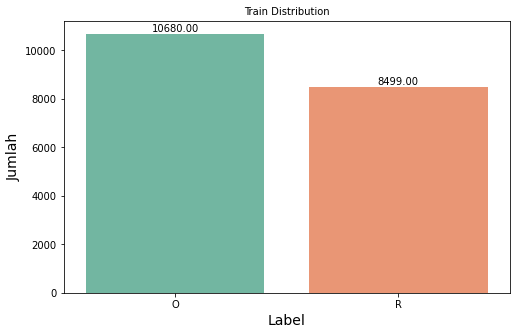

In [ ]:
# Membuat visualisasi untuk menampilkan persebaran jenis sampah
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(train_df, 'Train')

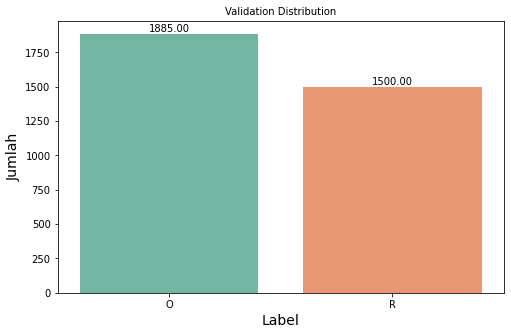

In [ ]:
visualize_data(val_df, 'Validation')

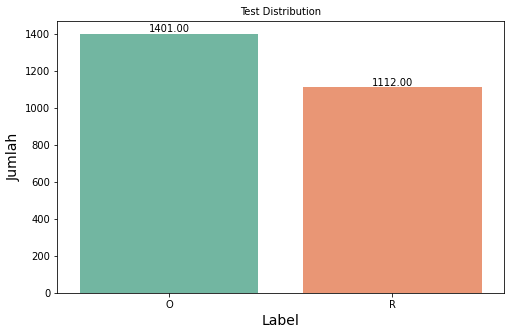

In [ ]:
visualize_data(test_df, 'Test')

Menurut saya persebaran label dalam tiap set sudah cukup seimbang sehingga tidak perlu dilakukan handling.

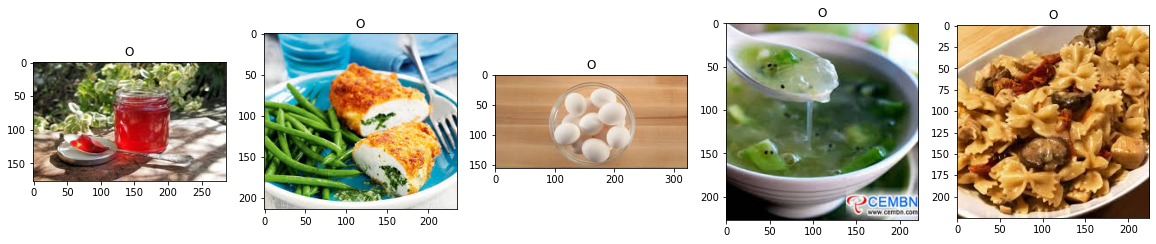

In [ ]:
# Menampilkan contoh gambar untuk tiap label
organic_samples = (train_df[train_df['label']=="O"]['images'].iloc[1:6]).tolist()
recycle_samples = (train_df[train_df['label']=='R']['images'].iloc[1:6]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i%5].set_title(sample.split('/')[-2])
        ax[i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(organic_samples)

Visual di atas menunjukan contoh gambar yang memiliki label `Organic`. Sampah organik merupakan sampah yang berasal dari sisa-sisa organisme makhluk hidup baik manusia, hewan, serta tumbuhan jadi contoh sampah organic pada dataset ini kebanyakan adalah gambar makanan atau bahan makanan.

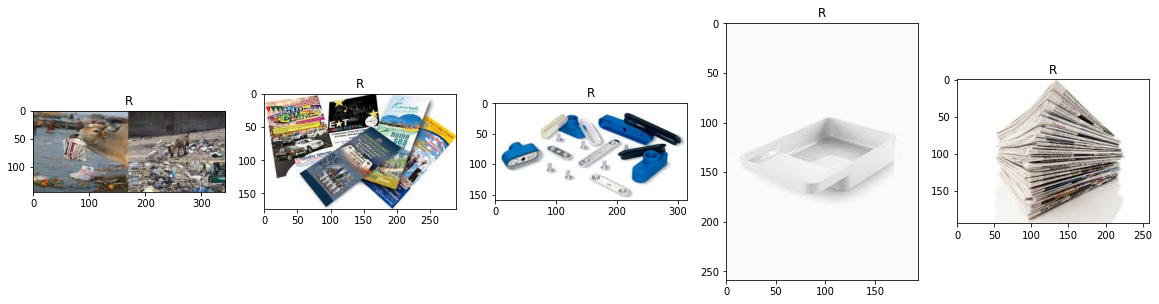

In [ ]:
visualize_samples(recycle_samples)

Sampah anorganik adalah sampah yang berasal bukan dari makhluk hidup. Sampah anorganik merupakan sampah yang tidak dapat diuraikan oleh mikroorganisme. Visual di atas menunjukan contoh sampah anorganic seperti kertas, besi, gelas, dan lain sebagainya.

# Data Preprocessing

## Data Augmentasi

In [ ]:
img_height = 128
img_width = 128
SEED = 1
BATCH = 128

Sebelum dilakukan data augmentasi, kita mengatur supaya tinggi dan lebar gambar menjadi sama yaitu 128 pixel dengan jumlah batch 128.

In [ ]:
# Membuat pengaturan image generator untuk augmentasi data
train_generator = ImageDataGenerator(rescale=1./255, #normalisasi pixel
                                    rotation_range=0.1,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

val_generator = ImageDataGenerator(rescale=1./255)

test_generator = ImageDataGenerator(rescale=1./255)

Augmentasi data merupakan suatu teknik untuk memperluas/menambahkan kumpulan data untuk mengurangi overfitting. Augmentasi yang dipilih pada kasus ini adalah :
* Rotasi gambar secara random sejauh 0.1 derajat.
* Menggeser gambar sebanyak 20% dari total width.
* Menggeser gambar sebanyak 20% dari total height.
* Tranvesi/memiringkan gambar sejauh 0.2 derajat.
* Zoom gambar sejauh 0.2.
* Melakukan horizontal flip pada gambar

Augmentasi data hanya dilakukan pada train, sedangkan untuk val set dan test set hanya dilakukan scaling.

In [ ]:
# Melakukan image generator menggunakan data dari dataframe yang sudah dibuat di atas 
train = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

Found 19179 validated image filenames belonging to 2 classes.


In [ ]:
val = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 3385 validated image filenames belonging to 2 classes.


In [ ]:
test = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 2513 validated image filenames belonging to 2 classes.


In [ ]:
train_class = train.class_indices
print('Train Set Class Label : ', train_class)

val_class = val.class_indices
print('Val Set Class Label : ', val_class)

test_class = test.class_indices
print('Test Set Class Label : ', test_class)

Train Set Class Label :  {'O': 0, 'R': 1}
Val Set Class Label :  {'O': 0, 'R': 1}
Test Set Class Label :  {'O': 0, 'R': 1}


Kita bisa lihat terdapat 2 label sampah pada tiap data set yaitu `O` untuk `Organic` dan `R` untuk `Recycle`.

# Model Definition

In [ ]:
callbacks = [ 
    EarlyStopping(monitor = 'val_loss', patience = 4), 
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)
]

Sebelum mengatur model, kita akan mengatur callback untuk saat training. Patience di set 3 dengan monitor val_loss dimana artinya jika saat training val_loss mengalami penurunan pada 3 epoch selanjutnya maka traning akan berhenti dan model akan disimpan sesuai dengan epoch sebelum mengalami penurunan.

In [ ]:
inputs= [img_height,img_width,3]

model= Sequential()

#Conv 1
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=inputs))
model.add(MaxPooling2D(pool_size=2, strides=2))

#Flatten
model.add(Flatten())

#Hidden Layer 1
model.add(Dense(units=16, activation='relu'))

#Output Layer
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 63504)             0         
                                                                 
 dense (Dense)               (None, 16)                1016080   
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,016,545
Trainable params: 1,016,545
Non-trainable params: 0
______________________________________________

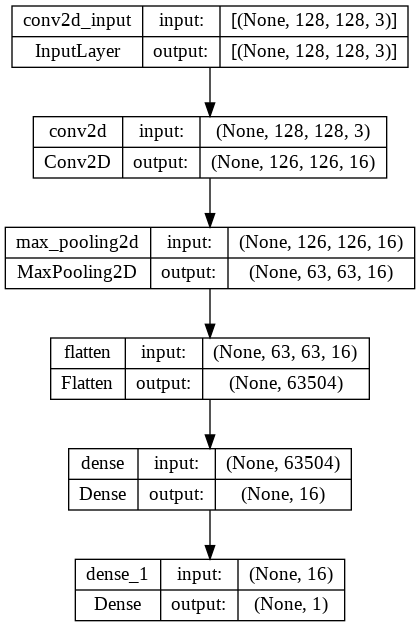

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Untuk model baseline dibuat sesuai arsitektur di atas. Model kita memiliki convolutional layer sejumlah 2 layer dimana layer pertama memiliki filter 3x3 sejumlah 16 filter sedangkan pada layer kedua jumlah filternya 32. Setelah setiap convolusi kita juga melakukan maxpooling dengan pool 2x2 yang bergeser 2 piksel. Selanjutnya hasil convolusi akan di flatten dimana selanjutnya masuk ke hidden layer pertama dengan jumlah neuron 64 dan terakhir menuju output layer dengan jumlah neuron 1 dan activation sigmoid karena merupakan binary classification.

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

Sebelum di train model akan dicompile dulu dengan menggunakan adam sebagai optimizer.

# Model Training

In [ ]:
history = model.fit(train, 
                    batch_size = BATCH, 
                    epochs = 20, 
                    validation_data = val, 
                    callbacks = callbacks,
                    verbose = 1)

Epoch 1/20
150/150 [==============================] - 99s 594ms/step - loss: 0.5435 - accuracy: 0.7707 - val_loss: 0.4430 - val_accuracy: 0.8032
Epoch 2/20
150/150 [==============================] - 90s 598ms/step - loss: 0.4419 - accuracy: 0.8050 - val_loss: 0.4214 - val_accuracy: 0.8151
Epoch 3/20
150/150 [==============================] - 89s 596ms/step - loss: 0.4251 - accuracy: 0.8120 - val_loss: 0.4642 - val_accuracy: 0.8100
Epoch 4/20
150/150 [==============================] - 88s 588ms/step - loss: 0.4184 - accuracy: 0.8155 - val_loss: 0.4101 - val_accuracy: 0.8154
Epoch 5/20
150/150 [==============================] - 89s 593ms/step - loss: 0.4101 - accuracy: 0.8226 - val_loss: 0.4402 - val_accuracy: 0.8157
Epoch 6/20
150/150 [==============================] - 90s 598ms/step - loss: 0.4010 - accuracy: 0.8243 - val_loss: 0.4367 - val_accuracy: 0.8195
Epoch 7/20
150/150 [==============================] - 89s 591ms/step - loss: 0.3964 - accuracy: 0.8285 - val_loss: 0.4471 - val_ac

# Model Evaluation

## Model Scoring

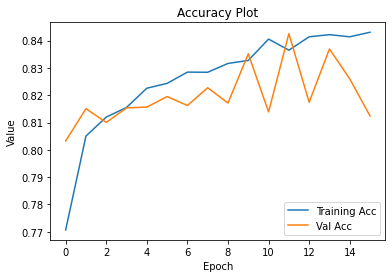

In [ ]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

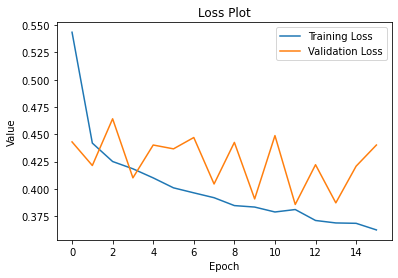

In [ ]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

Kita bisa melihat proses training model pada grafik loss dan accuracy. Pada graph accuracy kita melihat bahwa pada accuracy pada train set sangat bagus dan juga meningkat tiap epochnya sedangkan accuracy pada val set cenderung naik turun atau biasa disebut exploding gradient. Pada graph loss kita bisa melihat loss pada train set sangat bagus karena nilainya menurun tiap epoch dan pada epoch terakhir nilainya juga sangat rendah, sedangkan loss pada val set cenderung naik turun tidak stabil. 

Model hasil training selanjutnya akan dilakukan testing menggunakan test set.

In [ ]:
test_results = model.evaluate(test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.4092
Test Accuracy : 0.8357


In [ ]:
y_pred = model.predict(test)
y_pred_final = []

for i in y_pred:
  if i > 0.5:
    i = 1
    y_pred_final.append(i)
  else:
    i = 0
    y_pred_final.append(i)


print(classification_report(test.classes, y_pred_final))

20/20 [==============================] - 3s 150ms/step
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1401
           1       0.79      0.85      0.82      1112

    accuracy                           0.84      2513
   macro avg       0.83      0.84      0.83      2513
weighted avg       0.84      0.84      0.84      2513



Model baseline kita berhasil mendapatkan accuracy sebesar 0.84 pada test set.

Label 0 - Organic :
* Nilai precision 0.87 artinya model berhasil memprediksi 87% label organic ke organic sedangkan 13% sisanya diprediksi sebagai recycle. Nilai recall 0.82 artinya model berhasil memprediksi 82% label organic dengan benar dan 18% sisanya yang seharusnya recycle namun dimasukan ke label organic.

Label 1 - Recycle :
* Nilai precision 0.79 artinya model berhasil memprediksi 79% label recycle ke recycle sedangkan 21% sisanya diprediksi sebagai organic. Nilai recall 0.85 artinya model berhasil memprediksi 85% label recycle dengan benar dan 15% sisanya yang seharusnya organic namun dimasukan ke label recycle.

Confusion Matrix


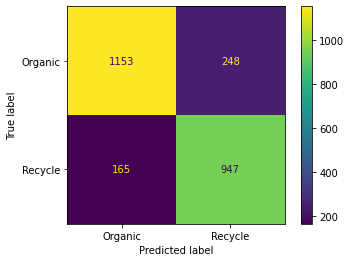

In [ ]:
#confusion matrix for test dataset
print('Confusion Matrix')
confmat = confusion_matrix(test.classes, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['Organic','Recycle'])
disp.plot()
plt.show()

Visual di atas menunjukan persebaran data hasil prediksi :
* 1153 label organic benar diprediksi sebagai organic
* 248 label organic salah diprediksi sebagai recycle
* 947 label recycle benar diprediksi sebagai recycle
* 165 label recycle salah diprediksi sebagai organic


## Model Tuning

In [ ]:
inputs= [img_height,img_width,3]

model2= Sequential()

#Conv 1
model2.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=inputs))
model2.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 2
model2.add(Conv2D(filters=64, kernel_size=3, activation= 'relu'))
model2.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 3
model2.add(Conv2D(filters=128, kernel_size=3, activation= 'relu'))
model2.add(MaxPooling2D(pool_size=2, strides=2))

#Flatten
model2.add(Flatten())

#Hidden Layer 1
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(0.5))

#Hidden Layer 2
model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(0.5))

#Output Layer
model2.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 128)     

Untuk model improvement sudah dibuat sesuai arsitektur di atas. Model memiliki convolutional layer sejumlah 3 layer dimana layer pertama memiliki filter 3x3 sejumlah 32 filter sedangkan pada layer kedua jumlah filternya 64 dan pada layer ketiga jumlah filternya sebanyak 128. Setelah setiap convolusi kita juga melakukan maxpooling dengan pool 2x2 yang bergeser 2 piksel. Selanjutnya hasil convolusi akan di flatten dimana selanjutnya masuk ke hidden layer pertama dengan jumlah neuron 128, lalu masuk ke hidden layer kedua dengan jumlah neuron 64, dan terakhir menuju output layer dengan jumlah neuron 1 dan activation sigmoid karena merupakan binary classification.

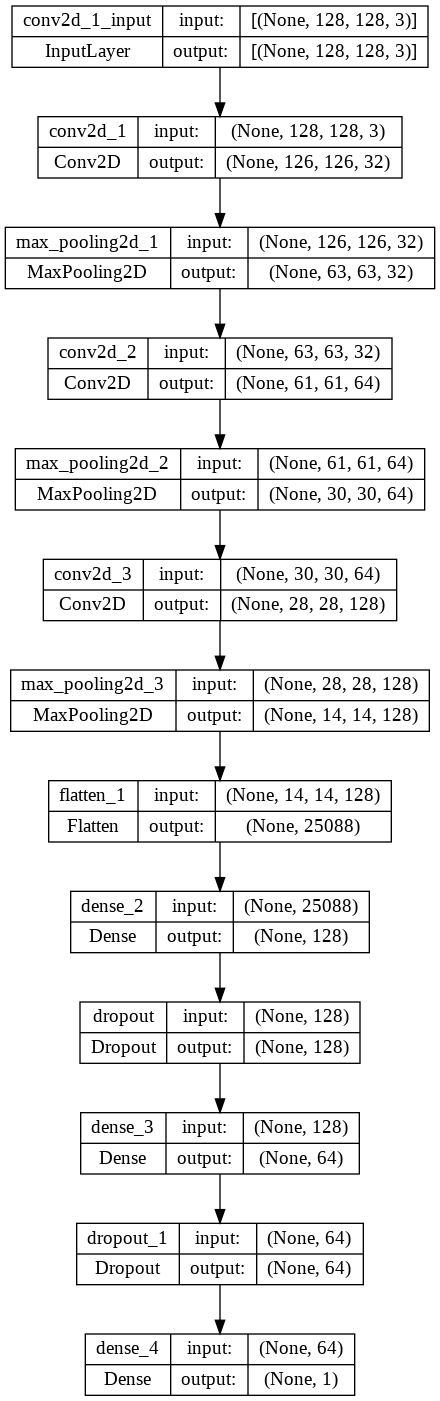

In [ ]:
tf.keras.utils.plot_model(model2, show_shapes=True)

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

Sebelum di train model akan dicompile dulu dengan menggunakan adam sebagai optimizer.

Model akan di train dengan epoch sebanyak 20.

In [ ]:
history2 = model2.fit(train, 
                    batch_size= BATCH, 
                    epochs= 20, 
                    validation_data= val, 
                    callbacks= callbacks) #bisa atur verbose

Epoch 1/20
150/150 [==============================] - 94s 615ms/step - loss: 0.5009 - accuracy: 0.7764 - val_loss: 0.4456 - val_accuracy: 0.8127
Epoch 2/20
150/150 [==============================] - 97s 647ms/step - loss: 0.4264 - accuracy: 0.8212 - val_loss: 0.3943 - val_accuracy: 0.8183
Epoch 3/20
150/150 [==============================] - 112s 749ms/step - loss: 0.3893 - accuracy: 0.8409 - val_loss: 0.3568 - val_accuracy: 0.8414
Epoch 4/20
150/150 [==============================] - 108s 720ms/step - loss: 0.3661 - accuracy: 0.8486 - val_loss: 0.4379 - val_accuracy: 0.8080
Epoch 5/20
150/150 [==============================] - 95s 630ms/step - loss: 0.3594 - accuracy: 0.8540 - val_loss: 0.3498 - val_accuracy: 0.8555
Epoch 6/20
150/150 [==============================] - 91s 608ms/step - loss: 0.3440 - accuracy: 0.8641 - val_loss: 0.3399 - val_accuracy: 0.8588
Epoch 7/20
150/150 [==============================] - 91s 606ms/step - loss: 0.3411 - accuracy: 0.8642 - val_loss: 0.3150 - val_

## Tuning Evaluation

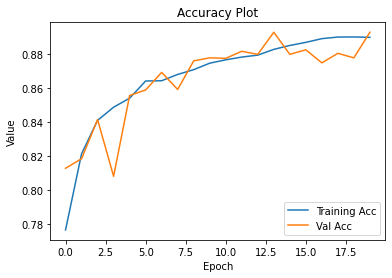

In [ ]:
plt.plot(history2.history['accuracy'], label='Training Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

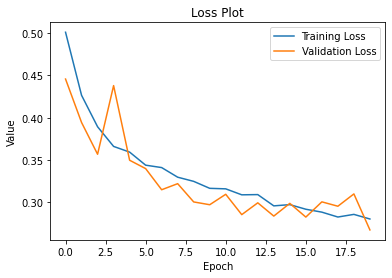

In [ ]:
#loss train & validation
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

Kita bisa melihat proses training model pada grafik loss dan accuracy. Pada graph accuracy kita melihat bahwa pada accuracy pada train set sangat bagus dan juga meningkat tiap epochnya dan accuracy pada val set mengikuti di sekitar garis train set. Pada graph loss kita bisa melihat loss pada train set sangat bagus karena nilainya menurun tiap epoch dan pada epoch terakhir nilainya juga sangat rendah dan loss pada val set mengikuti disekitar garis loss train set sehingga gap tidak terlalu besar.

In [ ]:
test_results = model2.evaluate(test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.2318
Test Accuracy : 0.9164


In [ ]:
y_pred2 = model2.predict(test)
y_pred_final2 = []

for i in y_pred2:
  if i > 0.5:
    i = 1
    y_pred_final2.append(i)
  else:
    i = 0
    y_pred_final2.append(i)


print(classification_report(test.classes, y_pred_final2))

20/20 [==============================] - 3s 155ms/step
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1401
           1       0.95      0.85      0.90      1112

    accuracy                           0.92      2513
   macro avg       0.92      0.91      0.91      2513
weighted avg       0.92      0.92      0.92      2513



Model improvement kita berhasil mendapatkan accuracy sebesar 0.92 pada test set.

Label 0 - Organic :
* Nilai precision 0.89 artinya model berhasil memprediksi 89% label organic ke organic sedangkan 11% sisanya diprediksi sebagai recycle. Nilai recall 0.97 artinya model berhasil memprediksi 97% label organic dengan benar dan 3% sisanya yang seharusnya recycle namun dimasukan ke label organic.

Label 1 - Recycle :
* Nilai precision 0.95 artinya model berhasil memprediksi 95% label recycle ke recycle sedangkan 5% sisanya diprediksi sebagai organic. Nilai recall 0.85 artinya model berhasil memprediksi 85% label recycle dengan benar dan 15% sisanya yang seharusnya organic namun dimasukan ke label recycle.

Confusion Matrix


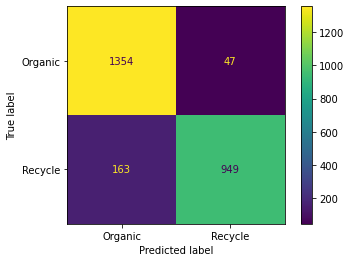

In [ ]:
#confusion matrix for test dataset
print('Confusion Matrix')
confmat = confusion_matrix(test.classes, y_pred_final2)
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['Organic','Recycle'])
disp.plot()
plt.show()

Visual di atas menunjukan persebaran data hasil prediksi :
* 1354 label organic benar diprediksi sebagai organic
* 47 label organic salah diprediksi sebagai recycle
* 949 label recycle benar diprediksi sebagai recycle
* 163 label recycle salah diprediksi sebagai organic

# Model Saving

Karena model hasil improvement memiliki result yang lebih baik maka kita akan memilih model hasil improvement untuk kita save.

In [ ]:
# freeze model
model2.trainable = False

In [ ]:
# save model
model2.save("model_waste")

In [ ]:
! zip -r model_waste.zip model_waste

  adding: model_waste/ (stored 0%)
  adding: model_waste/keras_metadata.pb (deflated 92%)
  adding: model_waste/variables/ (stored 0%)
  adding: model_waste/variables/variables.data-00000-of-00001 (deflated 24%)
  adding: model_waste/variables/variables.index (deflated 67%)
  adding: model_waste/saved_model.pb (deflated 89%)
  adding: model_waste/assets/ (stored 0%)


In [ ]:
model2.save("model2.h5")

# Model Inference

Untuk inference kita akan upload gambar dimana selanjutnya akan coba diprediksi oleh model hasil improvement

Saving Harga-Gelas-Plastik-Berbagai-Model-min.png to Harga-Gelas-Plastik-Berbagai-Model-min (1).png


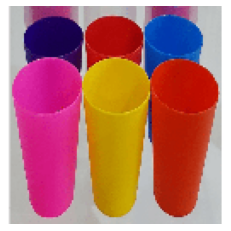

1/1 [==============================] - 0s 15ms/step
[[1.]]
recycle


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = load_img(path, target_size=(128,128)) #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = model.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] > 0.5:
    print('recycle')
  else:
    print('organic')

Saving 153704-1606331887.jpeg to 153704-1606331887.jpeg


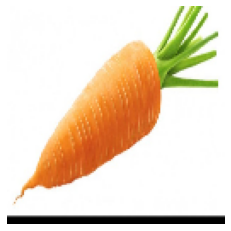

1/1 [==============================] - 0s 15ms/step
[[0.]]
organic


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = load_img(path, target_size=(128,128)) #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = model.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] > 0.5:
    print('recycle')
  else:
    print('organic')

Model hasil improvement kita berhasil memprediksi gambar yang diupload dengan benar. Gambar pertama adalah gelas plastik dimana plastik termasuk sampah anorganic, dan model kita berhasil memprediksi dengan benar. Untuk gambar kedua adalah gambar wortel dimana merupakan sampah organic dan model berhasil memprediksi gambar tersebut sebagai organic.

# Kesimpulan

Pengelolaan sampah merupakan salah satu yang harus dihadapi masyarakat sekarang. Limbah sampah yang menumpuk ini harus dikelola sesuai dengan jenisnya yaitu organic dan anorganic. Dataset kali ini berisi data-data gambar benda-benda yang termasuk limbah organic dan anorganic. Sampah organik merupakan sampah yang berasal dari sisa-sisa organisme makhluk hidup baik manusia, hewan, serta tumbuhan dan bisa diurai oleh mikroorganisme. Sampah anorganik adalah sampah yang berasal bukan dari makhluk hidup dan tidak dapat diuraikan oleh mikroorganisme. 

Model yang dibuat untuk prediksi adalah 2 model sequential dengan arsitektur yang berbeda. 

`Model baseline` yang dibuat  memiliki convolutional layer sejumlah 2 layer dimana layer pertama memiliki filter 3x3 sejumlah 16 filter sedangkan pada layer kedua jumlah filternya 32. Setelah setiap convolusi kita juga melakukan maxpooling dengan pool 2x2 yang bergeser 2 piksel. Selanjutnya hasil convolusi akan di flatten dimana selanjutnya masuk ke hidden layer pertama dengan jumlah neuron 64 dan terakhir menuju output layer dengan jumlah neuron 1 dan activation sigmoid karena merupakan binary classification. 

`Model baseline`  berhasil mendapatkan accuracy sebesar 0.84 pada test set.

**Label 0 - Organic** :

* Nilai precision 0.87 artinya model berhasil memprediksi 87% label organic ke organic sedangkan 13% sisanya diprediksi sebagai recycle. Nilai recall 0.82 artinya model berhasil memprediksi 82% label organic dengan benar dan 18% sisanya yang seharusnya recycle namun dimasukan ke label organic.

**Label 1 - Recycle** :

* Nilai precision 0.79 artinya model berhasil memprediksi 79% label recycle ke recycle sedangkan 21% sisanya diprediksi sebagai organic. Nilai recall 0.85 artinya model berhasil memprediksi 85% label recycle dengan benar dan 15% sisanya yang seharusnya organic namun dimasukan ke label recycle.

`Model improvement` yang dibuat memiliki convolutional layer sejumlah 3 layer dimana layer pertama memiliki filter 3x3 sejumlah 32 filter sedangkan pada layer kedua jumlah filternya 64 dan pada layer ketiga jumlah filternya sebanyak 128. Setelah setiap convolusi kita juga melakukan maxpooling dengan pool 2x2 yang bergeser 2 piksel. Selanjutnya hasil convolusi akan di flatten dimana selanjutnya masuk ke hidden layer pertama dengan jumlah neuron 128, lalu masuk ke hidden layer kedua dengan jumlah neuron 64, dan terakhir menuju output layer dengan jumlah neuron 1 dan activation sigmoid karena merupakan binary classification.

`Model improvement` kita berhasil mendapatkan accuracy sebesar 0.84 pada test set.

**Label 0 - Organic** :

* Nilai precision 0.87 artinya model berhasil memprediksi 87% label organic ke organic sedangkan 13% sisanya diprediksi sebagai recycle. Nilai recall 0.82 artinya model berhasil memprediksi 82% label organic dengan benar dan 18% sisanya yang seharusnya recycle namun dimasukan ke label organic.

**Label 1 - Recycle** :

* Nilai precision 0.79 artinya model berhasil memprediksi 79% label recycle ke recycle sedangkan 21% sisanya diprediksi sebagai organic. Nilai recall 0.85 artinya model berhasil memprediksi 85% label recycle dengan benar dan 15% sisanya yang seharusnya organic namun dimasukan ke label recycle.

Jadi model hasil improvement yang sudah dibuat berhasil mendapatkan hasil yang cukup baik dan berhasil memprediksi apakah suatu gambar merupakan sampah organic atau anorganic(recycle). 

**Saran** :

Menggunakan dataset yang berisi gambar benda yang sudah berbentuk sampah, bukan benda aslinya yang masih bagus sehingga bisa benar-benar memprediksi gambar sampah saat sudah menjadi bentuk sampah/rusak.

